# Fine-tuning our favourite Puppet
- This notebook is a guide on how to finetune `bert-base-uncased` for binary classification task
- We are using the (Fake News Detection)[https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data] dataset from Kaggle
    - Under the `fake_real` directory you will find `Fake.csv` and `True.csv`, each csv file has these fields **title,text,subject,date**
    - We will only be using a sample of 10% (total)

### Imports

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

sns.set_theme(style='whitegrid')

# Data Cleaning
- Here we will be using the `pandas` library to read our csvs
    - We create the dataframes (df)
    - We add the field `label` to our dataframes, all entries from `Fake.csv` will have the label `0`, entries from `True.csv` will have the label `1`
    - We then concatenate both dataframes into one dataframe
    - We create a random sample of 10% of our data (we set our seed for reproducibility)
    - When we sample our data, indexes of each entry will stay the same, so we use `reset_index(drop=True)` to get newly ordered indexes

In [15]:
fake_df = pd.read_csv('fake_real/Fake.csv')
true_df = pd.read_csv('fake_real/True.csv')

fake_df['label'] = 0
true_df['label'] = 1

fake_df = fake_df.drop(columns=['subject','date'])
true_df = true_df.drop(columns=['subject','date'])

fake_df = fake_df.drop_duplicates(subset=['text'])
true_df = true_df.drop_duplicates(subset=['text'])

df = pd.concat([fake_df, true_df], ignore_index=True)

print('Original Dataset size:', len(df))

sample_df = df.sample(frac=0.10, random_state=42).reset_index(drop=True)

print('10% sample size:', len(sample_df))

Original Dataset size: 38647
10% sample size: 3865


### Train / Validation / Test Split

- We use `train_test_split` from `sklearn` to divide our **10%** sample into three subsets
    - First, we create the test set, which will contain **20%** of the sampled data
    - We set a our seed for reproducibility
    - We use the `stratify` argument to ensure the class distribution (label 0/1) remains the same in both the *training* and *test* sets
    - Next, we take the remaining *training* portion and split it again:
        - 20% of this subset becomes our *validation* set, used during training to monitor model performance
        - Again, we use the *stratify* parameter to preserve label balance

In [16]:
train_df, test_df = train_test_split(sample_df, test_size=0.20, random_state=42, stratify=sample_df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42, stratify=train_df['label'])

print('Train:', len(train_df), '\nValidation:', len(val_df), '\nTest:', len(test_df))

Train: 2473 
Validation: 619 
Test: 773


### From df to hf Datasets
- We define a function `hf_format` that converts a pandas dataframe into a HuggingFace Dataset
    - We keep only the text and label columns, since the model does not require any additional metadata
    - We set `preserve_index=False` to avoid keeping the original pandas index (which prevents accidental index-based leakage)
- We then construct a `DatasetDict`, a container used by HuggingFace to store multiple dataset splits together
    - Each split (train, validation, test) is created by applying our `hf_format` function to the corresponding pandas dataframe.
    - This structure ensures that all dataset splits are in a consistent, *model-ready* format before tokenization.

In [17]:
def hf_format(df):
    return Dataset.from_pandas(df[['text','label']], preserve_index=False)

dataset = DatasetDict({
    'train': hf_format(train_df),
    'validation': hf_format(val_df),
    'test': hf_format(test_df)
})

### Tokenization
- We first load a pretrained BERT `tokenizer` (bert-base-uncased), which will convert raw text into token IDs that the model can process
- We define a tokenize function that applies the tokenizer to each batch of samples:
    - `truncation=True` ensures that texts longer than the model's maximum input length are safely truncated
    - `padding='max_length'` pads shorter texts so all sequences have the same length
    - `max_length=256` sets a fixed input length for all samples, which simplifies batching and improves training stability
- We apply this tokenization function to the entire dataset using `dataset.map(...)`, enabling efficient, batched preprocessing
- The original text column is removed (`remove.columns`), since the model will now operate on tokenized tensors instead of raw strings
- We rename the label column to labels, which is the field name expected by HuggingFace models during training
    - When the Dataset was created, I purposely used "label" instead of "labels" to showcase the `rename_column` function (sometimes this function is really essential)
- Finally, we set the dataset format to torch, allowing PyTorch tensors to be returned during training and evaluation.

In [18]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(['text'])
dataset = dataset.rename_column('label','labels')
dataset.set_format('torch')

Map:   0%|          | 0/2473 [00:00<?, ? examples/s]

Map:   0%|          | 0/619 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

### No fine-tuning? Let's evaluate our model on our test data without fine-tuning (a Baseline of some sort)

- We load a pretrained BERT model `bert-base-uncased` with two output labels (fake vs. real)
- At this stage, the model has not been fine-tuned on our dataset, making this a true baseline
- We create a PyTorch DataLoader for the test split, using a `batch_size` of 8 to efficiently iterate through the data
##### Note: Inference was already treated in the last exercise, if you still remember the fundamentals of how to run inference, you can skip the explanation below
- Before running inference, we set the model to evaluation mode using `eval()` and wrap the loop inside `torch.no_grad()` to disable gradient calculations, reducing memory usage and improving speed
    - For each batch:
        - We pass the batch through the model to obtain raw output logits
        - We store these logits on the CPU for later processing
        - After processing all batches, we concatenate the logits and compute predicted class labels using argmax
##### Let's understand our output
- We extract the true labels from the dataset and print a full **classification report**
- Finally, we compute a confusion matrix and visualize it using a heatmap to inspect how the model performs on each class before any fine-tuning

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating Baseline Model: 100%|██████████| 97/97 [00:10<00:00,  9.63it/s]



BASELINE (Without Fine-Tuning)
              precision    recall  f1-score   support

           0       0.46      0.73      0.56       353
           1       0.54      0.28      0.37       420

    accuracy                           0.48       773
   macro avg       0.50      0.50      0.46       773
weighted avg       0.50      0.48      0.46       773



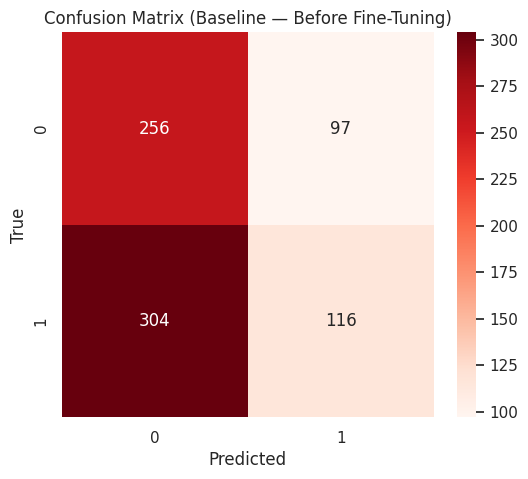

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=8)
all_logits = []

baseline_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating Baseline Model"):
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = baseline_model(**batch)
        all_logits.append(outputs.logits.cpu())

all_logits = torch.cat(all_logits, dim=0)
baseline_preds = torch.argmax(all_logits, dim=1).numpy()
true_labels = dataset['test']['labels']

print("\nBASELINE (Without Fine-Tuning)")
print(classification_report(true_labels, baseline_preds, zero_division=0))

cm = confusion_matrix(true_labels, baseline_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix (Baseline — Before Fine-Tuning)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Let's Fine-tune!!!
- We load a fresh instance of BERT model
- We define the training configuration using HuggingFace's `TrainingArguments`:
    - `output_dir` specifies where model checkpoints and logs will be saved
    - `per_device_train_batch_size` and `per_device_eval_batch_size` determine how many samples are processed at once during training and validation.
    - `num_train_epochs=1` means the model will make one full pass over the training data
    - `learning_rate=2e-5` is a common choice for fine-tuning BERT, balancing stability and adaptability
    - `weight_decay=0.01` adds regularization to help prevent overfitting
    - `logging_steps=50` controls how frequently training metrics are logged
    - `save_strategy='epoch'` ensures a checkpoint is saved after each epoch
    - `report_to='none'` disables integrations with external logging tools (if this parameter is not declared, it automatically tries to report to Weights and Biases, it will ask for your api key, so if you are intending to report it to a local provider or an API just set it to `none`)
- We create a Trainer object, which handles the entire training loop:
    - We pass the model to be fine-tuned
    - We provide the training arguments defined above
    - We supply the training split and validation split, enabling the trainer to evaluate the model during training

In [20]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir='./finetuned_bert_10pct',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy='epoch',
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation']
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



- We call trainer.train() to begin the fine-tuning process using the configuration and datasets we previously defined

In [21]:
trainer.train()

Step,Training Loss
50,0.253000
100,0.020300
150,0.013600
200,0.016700
250,0.023800
300,0.032900


TrainOutput(global_step=310, training_loss=0.05814616119699372, metrics={'train_runtime': 111.182, 'train_samples_per_second': 22.243, 'train_steps_per_second': 2.788, 'total_flos': 325336819952640.0, 'train_loss': 0.05814616119699372, 'epoch': 1.0})

#### Real Evaluation
- We use `trainer.predict(dataset['test'])` to generate model outputs on the test set
- The prediction process and output structure were explained earlier in the baseline evaluation section
- We extract the predicted class labels by applying argmax to the model’s logits
    - We retrieve the true labels from the test dataset for comparison
    - We print a full classification report to evaluate performance after fine-tuning, including precision, recall, and F1-score for each class
    - We set zero_division=0 to avoid warnings if a class receives no predicted samples
- We compute a confusion matrix to visualize the distribution of correct vs. incorrect predictions across both classes
    - We plot the confusion matrix using a heatmap for easier interpretation, labeling the axes and adding a descriptive title


### AFTER FINE-TUNING ###
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       353
           1       1.00      1.00      1.00       420

    accuracy                           1.00       773
   macro avg       1.00      1.00      1.00       773
weighted avg       1.00      1.00      1.00       773



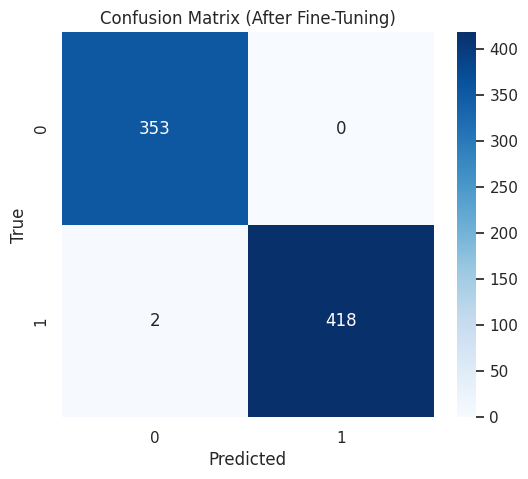

In [22]:
pred_output = trainer.predict(dataset['test'])
pred_labels = np.argmax(pred_output.predictions, axis=1)
true_labels = dataset['test']['labels']

print("\n### AFTER FINE-TUNING ###")
print(classification_report(true_labels, pred_labels, zero_division=0))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (After Fine-Tuning)')
plt.show()